![CAT_DOG](img/bannière.png)

# 📌 Contexte du projet

Une équipe médicale souhaite explorer l'apport de l'intelligence artificielle dans le diagnostic automatisé de la **pneumonie** à partir de **radios thoraciques**.

🎯 Objectif :
Développer un **prototype fonctionnel (Proof of Concept)** capable de **classer automatiquement** une image en :
- Pneumonie
- Pas de pneumonie

Le système repose sur la **réutilisation d’un modèle pré-entraîné** de type CNN (réduction du coût d’entraînement).  
Le modèle choisi est **DenseNet121**, avec les **poids CheXNet** (entraînés sur le jeu de données ChestX-ray14), adaptés à la classification médicale.

🛠️ Suivi des expériences :  
Le projet intègre **MLflow** pour le suivi des essais, la traçabilité des modèles et les performances dans une logique **MLOps**.



- modèle à utiliser: CheXNet (ou le réseau de neuronne qui à permis de le faire : Densenet121)

## 📦 1. Chargement des bibliothèques nécessaires

Cette section prépare l’environnement pour :

- la gestion des données et des images (`numpy`, `matplotlib`, etc.),
- l’interaction avec MLflow via `mlflow.keras` et `MlflowClient`,
- le chargement dynamique du **dernier modèle versionné** depuis le **Model Registry MLflow**.

Nous utilisons `TensorFlow/Keras` comme framework principal, et MLflow pour le suivi et le chargement du modèle.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from datetime import datetime
from time import strftime
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

#librairie tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping

#librairie mlflow
import mlflow
import mlflow.tensorflow
from mlflow.models.signature import infer_signature
from mlflow.data import Dataset
from mlflow.tracking import MlflowClient
import mlflow.keras


IMAGE_PIXEL = (224, 224)


np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30) 

Erreur lors de la désactivation du GPU.


2025-05-24 14:23:42.046124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748089422.061398   13828 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748089422.065736   13828 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748089422.076905   13828 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748089422.076929   13828 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748089422.076930   13828 computation_placer.cc:177] computation placer alr

## 🖥️ Vérification utilisation carte graphique



In [2]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             print(f"Nom du GPU détecté : {gpu.name}")
#         logical_gpus = tf.config.list_logical_devices('GPU')
#         print(f"{len(gpus)} GPU(s) physique(s), {len(logical_gpus)} GPU(s) logique(s)")
        
#         # Afficher les infos depuis le runtime TensorFlow
#         from tensorflow.python.client import device_lib
#         devices = device_lib.list_local_devices()
#         for device in devices:
#             if device.device_type == 'GPU':
#                 print("Nom      :", device.name)
#                 print("Type     :", device.device_type)
#                 print("Mémoire  :", round(device.memory_limit / (1024**3), 2), "GB")
#                 print("---------")
#     except RuntimeError as e:
#         print(e)
# else:
#     print("Aucun GPU détecté.")

## 🔍 2. Exploration des données

Nous examinons ici la structure du jeu de données pour comprendre les classes disponibles (`PNEUMONIA`, `NORMAL`) et visualiser quelques exemples d’images.

Cette étape permet de :
- vérifier que les données sont bien organisées,
- anticiper les besoins de prétraitement,
- s'assurer que le jeu de données est cohérent avant d'utiliser un modèle préentraîné.

Elle est essentielle pour garantir que les images soient compatibles avec le modèle DenseNet121 utilisé plus tard.

Classes disponibles : ['NORMAL', 'PNEUMONIA']
Classe : NORMAL
Type des valeurs : uint8
Shape (dimensions)    : (1611, 1792, 3)
Type des valeurs      : uint8


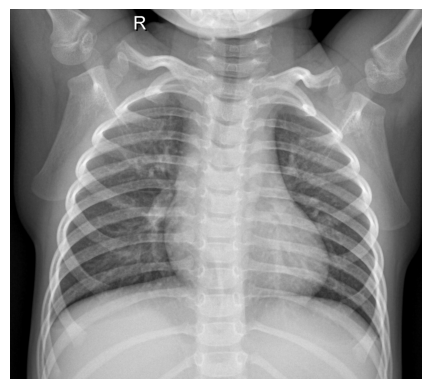

Classe : PNEUMONIA
Type des valeurs : uint8
Shape (dimensions)    : (912, 1368, 3)
Type des valeurs      : uint8


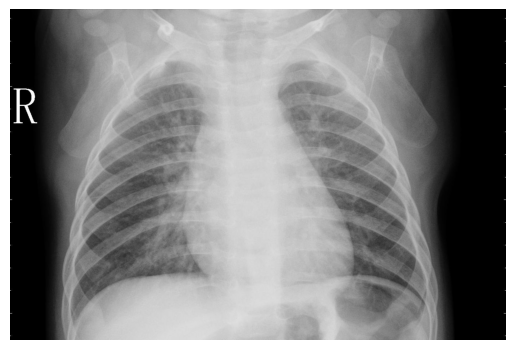

In [3]:
data_dir = "data/train"

classes = os.listdir(data_dir)
print("Classes disponibles :", classes)

for label in classes:
    path = os.path.join(data_dir, label)
    sample_img = random.choice(os.listdir(path))
    img = cv2.imread(os.path.join(path, sample_img), cv2.IMREAD_COLOR_RGB) #IMREAD_COLOR_RGB
    print(f"Classe : {label}")
    print(f"Type des valeurs : {img.dtype}")
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    # Inspection des métadonnées de l'image
    print(f"Shape (dimensions)    : {img.shape}")
    print(f"Type des valeurs      : {img.dtype}")
    plt.show()

## 🧪 3. Prétraitement des données

Nous préparons les images à être directement consommées par le modèle DenseNet121 :

- redimensionnement à 224x224 pixels,
- conversion en RGB (3 canaux),
- mise à l’échelle des pixels (valeurs entre 0 et 1).

Ces transformations sont réalisées automatiquement avec `ImageDataGenerator` pour les ensembles :
- `train`
- `validation`
- `test`

Ce prétraitement est crucial pour garantir que les données correspondent aux attentes du modèle.

In [4]:
# Prétraitement commun
datagen = ImageDataGenerator(rescale=1./255)

# Générateur pour l'entraînement
train_generator = datagen.flow_from_directory(
    'data/train',
    target_size=(IMAGE_PIXEL[0], IMAGE_PIXEL[1]),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

# Générateur pour le test final
test_generator = datagen.flow_from_directory(
    'data/test',
    target_size=(IMAGE_PIXEL[0], IMAGE_PIXEL[1]),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

# Générateur pour la validation
val_generator = datagen.flow_from_directory(
    'data/val',
    target_size=(IMAGE_PIXEL[0], IMAGE_PIXEL[1]),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## 🧠 4. Modélisation et suivi avec MLflow

Nous utilisons ici le modèle **DenseNet121** de `Keras` comme base, sans ses poids par défaut (`weights=None`), afin de le personnaliser pour notre cas d’usage.

### Étapes de modélisation :

1. **Reconstruction fidèle de l'architecture CheXNet** :  
   Pour pouvoir charger les poids `.h5` préentraînés, nous devons recréer exactement la structure d’origine du modèle CheXNet (14 classes en sortie).

2. **Chargement des poids CheXNet** :  
   Ces poids sont issus d’un entraînement sur le jeu de données **ChestX-ray14**, et permettent au modèle de bénéficier d’une bonne représentation des pathologies pulmonaires dès le départ.

3. **Adaptation pour notre tâche** :  
   Une fois les poids chargés, nous supprimons la couche de sortie d’origine (14 classes) et la remplaçons par une couche adaptée à notre besoin de **classification binaire** : `PNEUMONIA` vs `NORMAL`.

4. **Compilation du modèle** :  
   Le modèle est compilé pour une tâche de classification binaire avec une fonction de perte adaptée (`binary_crossentropy`), un optimiseur (ex. Adam) et des métriques pertinentes (accuracy, precision, etc.).

### Suivi avec MLflow

Nous utilisons **MLflow** pour suivre chaque expérimentation de manière rigoureuse :

- journalisation automatique des métriques d'entraînement (loss, accuracy, etc.),
- enregistrement des hyperparamètres et de la structure du modèle,
- sauvegarde du modèle entraîné pour une réutilisation future ou comparaison.

💡 Pour visualiser les essais dans l'interface MLflow :
```bash
mlflow ui

#### création de params

In [5]:
run_params = {
    "run_name": f"MobileNetV3Large-transfer { datetime.now().strftime('%Y-%m-%d %H:%M:%S') }",
    "description": "test du modele MobileNetV3Large"
}

params = {
    "base_model": "MobileNetV3Large",     # Nom du modèle de base pré-entraîné utilisé
    "frozen_epochs": 10,              # Nombre d’époques pour la phase 1 (entraînement du "head" avec le backbone gelé)
    "finetune_epochs": 10,            # Nombre d’époques pour la phase 2 (fine-tuning avec le backbone partiellement ou totalement dégelé)
    "lr_frozen": 1e-3,               # Learning rate (taux d’apprentissage) pour la phase 1
    "lr_finetune": 1e-5              # Learning rate pour la phase 2 (souvent plus bas pour éviter de détruire les poids pré-entraînés)
}

tags = {
    "framework": "Keras",
    "model_type": "CNN",
    "model": "MobileNetV3Large",
    "mlflow.dataset.name": "pneumonia_kaggle",
    "mlflow.dataset.context": "training",
    "mlflow.dataset.source_type": "url",
    "mlflow.dataset.source": "https://www.kaggle.com/datasets/nom_du_dataset"
}

#### création de fonction

In [ ]:
#sauvegarder toute les informations reçu dans les metrics de mlflow
def save_log_history(history, prefix="" ,metrics = ["loss", "val_loss", "accuracy", "val_accuracy"]):
    for i in range(len(history["loss"])):
        for metric in metrics:
            if metric in history:
                mlflow.log_metric(f"{prefix}_{metric}", history[metric][i], step= i)


#sauvegarder les graphs des performances dans mlflow             
def draw_graph(list_val, metric, epochs):
    epochs_frozen = list(range(1, len(list_val['frozen']) + 1))
    epochs_unfrozen = list(range(1, len(list_val['unfrozen']) + 1))
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(epochs_frozen, list_val['frozen'], label=f'Frozen {metric}', color='blue')
    ax.plot(epochs_unfrozen, list_val['unfrozen'], label=f'Unfrozen {metric}', color='orange')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(f'{metric}')
    ax.set_title(f'Training {metric} per Phase')
    ax.legend()
    ax.grid(True)
        
    mlflow.log_figure(fig, f"{metric}_comparison.png")

: 

#### création modele + utilisation de mlflow

In [ ]:
mlflow.set_experiment("Pneumonia Detection")
mlflow.keras.autolog(disable=True) # desactivation du log automatique
with mlflow.start_run(**run_params):
    
    #ajouter des info dans mlflow
    mlflow.set_tags(tags)
    mlflow.log_params(params)
        
    #mlflow.log_input(dataset, context="training")
    
    # Modèle basé sur DenseNet121
    input_tensor = layers.Input(shape=(IMAGE_PIXEL[0], IMAGE_PIXEL[1], 3))
    
    #utilisation du modele DenseNet (création sans poids afin de rajouter ceux de CheXNet)
    model_mobileNetV3 = MobileNetV3Large(weights='imagenet', include_top=False, input_tensor=input_tensor)

    x = model_mobileNetV3.output
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(1, activation='sigmoid')(x)   # Retirer la dernière couche et en ajouter une nouvelle
    model = models.Model(inputs=model_mobileNetV3.input, outputs=output)

    for layer in model.layers[:-1]:  # Freeze toutes les couches du modèle (sauf la nouvelle couche Dense)
        layer.trainable = False
    
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)       # éviter le surapprentissage
        
    # Compiler
    model.compile(
        optimizer=optimizers.Adam(params['lr_frozen']),          # Méthode d’optimisation (descente de gradient)
        loss='binary_crossentropy',                              # Fonction de perte pour classification multi-classe avec étiquettes entières (ex : 0 à 9)
        metrics=['accuracy'])                                    # On surveille l’exactitude pendant l'entraînement
    
    # print("Warmup...")
    # model.train_on_batch(train_generator)
    # print("Warmup terminé ✅")
    
    history_frozen = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs= params['frozen_epochs'],
    batch_size = 32,
    callbacks=[early_stop]
    )
    
    # Log manuel phase 1 (history_frozen)
    save_log_history(history=history_frozen.history, prefix="frozen")
       
    # Défiger certaines couches + recompiler
    for layer in model.layers[-11:]:
        layer.trainable = True

    # Recompiler après avoir modifié trainable
    model.compile(
        optimizer=optimizers.Adam(params['lr_finetune']),  #plus petit LR pour ne pas détruire les poids
        loss='binary_crossentropy',
        metrics=['accuracy'])

    # print("Warmup...")
    # model.train_on_batch(train_generator)
    # print("Warmup terminé ✅")

    # Deuxième phase d'entraînement (fine-tuning)
    history_unfrozen = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs= params['finetune_epochs'],
        batch_size = 32,
        callbacks=[early_stop]
    )
    
    # Log manuel phase 2 (history_unfrozen)
    save_log_history(history=history_unfrozen.history, prefix="unfrozen")

    # tracer les graph
    for metric in history_frozen.history:
        draw_graph({"frozen": history_frozen.history[metric], "unfrozen": history_unfrozen.history[metric] }, metric, 10)
    
    
    # Évaluation finale
    loss, acc = model.evaluate(test_generator)  
    mlflow.log_metric("final_test_loss", loss)
    mlflow.log_metric("final_test_accuracy", acc)
    
    # Exemple d'entrée : un batch aléatoire
    input_example = np.random.rand(1, IMAGE_PIXEL[0], IMAGE_PIXEL[1], 3).astype(np.float32)

    # Prédiction pour obtenir un exemple de sortie
    output_example = model.predict(input_example)

    # Déduire la signature
    signature = infer_signature(input_example, output_example)
    
    # sauvegarde du modele
    mlflow.keras.log_model(
        model,
        artifact_path="model",
        registered_model_name="Pneumonia_MobileNetV3Large_Model",
        signature= signature
    )


In [ ]:
# Résumé complet du modèle
#model.summary()
print(mlflow.__version__)

## 📈 5. Évaluation du modèle

Nous procédons à l’évaluation du modèle préalablement entraîné en analysant ses performances sur le jeu de validation.

### 🔍 Métriques utilisées

Pour obtenir une évaluation complète et fiable, nous utilisons plusieurs métriques complémentaires :

- **Accuracy** : proportion de prédictions correctes sur l’ensemble des échantillons.
- **Precision** : capacité du modèle à ne pas générer de faux positifs.
- **Recall (Sensibilité)** : capacité du modèle à détecter les vrais positifs.
- **F1-score** : compromis entre précision et rappel, particulièrement pertinent en cas de classes déséquilibrées.
- **Matrice de confusion** : représentation visuelle des erreurs de classification pour chaque classe.

Ces métriques ont été sélectionnées afin de refléter la performance du modèle dans un contexte médical, où les erreurs peuvent avoir des conséquences différentes selon leur nature (faux positifs vs faux négatifs).

### ✅ Chargement et test du modèle

Le modèle est rechargé depuis **MLflow** afin d’assurer la cohérence de l’évaluation avec la version sauvegardée lors de l'entraînement. Cette étape permet de valider que le modèle stocké est opérationnel et prêt à être comparé ou déployé.

## matrice de confusion

In [ ]:
# Étape 1 : Prédictions sur les données de test
y_pred_proba = model.predict(test_generator)
y_pred = (y_pred_proba > 0.5).astype("int").flatten()

# Étape 2 : Étiquettes vraies
y_true = test_generator.classes

# Étape 3 : Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

# Affichage avec seaborn
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel("Prédiction")
ax.set_ylabel("Vérité")
ax.set_title("Matrice de confusion")

plt.show()

## scores obtenu

In [ ]:
print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision :", precision_score(y_true, y_pred))
print("Recall :", recall_score(y_true, y_pred))
print("F-score :", f1_score(y_true, y_pred))

valeur importante: **Recall**
- mesure la capacité du modele à detecter les vrais pneumonie
- une pneumonie non detecter est plus grave que l'inverse (faux négatif)

## test du modele

In [ ]:
nommage = {0:"NORMAL", 1:"PNEUMONIA"}

# # === Nombre total d'images dans le test_generator
n_images = test_generator.samples

# # === Tirer un indice aléatoire entre 0 et n_images - 1
index = random.randint(0, n_images - 1)

# # === Calculer le batch et la position dans le batch
batch_size = test_generator.batch_size
batch_index = index // batch_size
image_index = index % batch_size

# # === Charger le batch correspondant
images_batch, labels_batch = test_generator[batch_index]

# # === Récupérer l’image et le label à cet index
img = images_batch[image_index]
label = labels_batch[image_index]

# # === Montrer l’image avec le label
plt.imshow(img)
plt.title(f"Label attendu : {nommage[label]}")
plt.axis('off')
plt.show()

# # === Prédiction
img_input = np.expand_dims(img, axis=0)
pred = model.predict(img_input)

# # === Interprétation
display(pred)

In [ ]:
# Crée un client MLflow
client = MlflowClient()

# Récupère toutes les versions du modèle
all_versions = client.search_model_versions("name='Pneumonia_CheXNet_Model'")

# Trie par version (en int) pour obtenir la dernière
latest_version_info = max(all_versions, key=lambda v: int(v.version))

# Crée l'URI du modèle
model_uri = f"models:/Pneumonia_CheXNet_Model/{latest_version_info.version}"

# Charge le modèle avec mlflow.keras
model = mlflow.keras.load_model(model_uri)

# # === Montrer l’image avec le label
plt.imshow(img)
plt.title(f"Label attendu : {nommage[label]}")
plt.axis('off')
plt.show()

# # === Prédiction
img_input = np.expand_dims(img, axis=0)
pred = model.predict(img_input)

# # === Interprétation
display(pred)

